# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



### Data Preperation

In [288]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the datasets provided
alldata = pd.read_excel('Data/alldata.xlsx')
drdata = pd.read_excel('Data/drdata.xlsx')
drq = pd.read_excel('Data/drq.xlsx')
tv2data = pd.read_excel('Data/tv2data.xlsx')
tv2q = pd.read_excel('Data/tv2q.xlsx')
electeddata = pd.read_excel('Data/electeddata.xlsx')

# Quick overview of the dataset
{
    "alldata": alldata.head(),
    "drdata": drdata.head(),
    "drq": drq.head(),
    "tv2data": tv2data.head(),
    "tv2q": tv2q.head(),
    "electeddata": electeddata.head()
}

{'alldata':    530  531  533  534  535  537  538  540  541  543  ...  9a  9b  10a  10b  \
 0   -1   -2    1   -2    2    1   -2    1    1    2  ...   2   0    1   -2   
 1    2    2   -1   -2   -1   -2    1   -2    2   -2  ...  -2   0   -1    2   
 2    2    1   -2   -2    1   -2    1   -1    1   -1  ...  -1  -2    0    2   
 3    2    1   -2   -1    1    1    1    1    1   -2  ...  -2   2    2    2   
 4    1    1   -2    2   -2    1   -2    1    2   -2  ...  -2   0   -1    0   
 
    11a  11b  12a  12b               storkreds  alder  
 0   -2    1    1    1    Københavns Storkreds     78  
 1    1   -2    0    0          Fyns Storkreds     64  
 2    0   -1    1   -2     Bornholms Storkreds     37  
 3    2   -1    2    0  Nordjyllands Storkreds     28  
 4   -2    0    2   -2    Københavns Storkreds     58  
 
 [5 rows x 53 columns],
 'drdata':    530  531  533  534  535  537  538  540  541  543  ...  552  553  555  556  \
 0   -1   -2    1   -2    2    1   -2    1    1    2  ...   

### Remove Unused Columns

In [289]:
# List of columns to drop
columns_to_drop = ["alder", "storkreds", "navn"]

# Drop the columns from the DataFrame
alldata_cleaned = alldata.drop(columns=columns_to_drop)

# Verify the result
print(alldata_cleaned.head())

   530  531  533  534  535  537  538  540  541  543  ...  8a  8b  9a  9b  10a  \
0   -1   -2    1   -2    2    1   -2    1    1    2  ...   1   0   2   0    1   
1    2    2   -1   -2   -1   -2    1   -2    2   -2  ...   0   0  -2   0   -1   
2    2    1   -2   -2    1   -2    1   -1    1   -1  ...   1   1  -1  -2    0   
3    2    1   -2   -1    1    1    1    1    1   -2  ...   2   2  -2   2    2   
4    1    1   -2    2   -2    1   -2    1    2   -2  ...   1   0  -2   0   -1   

   10b  11a  11b  12a  12b  
0   -2   -2    1    1    1  
1    2    1   -2    0    0  
2    2    0   -1    1   -2  
3    2    2   -1    2    0  
4    0   -2    0    2   -2  

[5 rows x 50 columns]


These columns are not relevant to the analysis we are preforming as we are only concerned with the questions, answers, and the parties involved with the answers.

### Question Analysis

In [290]:
# Define columns that aren't questions
non_question_columns = ['navn', 'parti', 'storkreds', 'alder']

# Identify question columns
question_columns = [col for col in alldata.columns if col not in non_question_columns]

# Calculate standard deviation for each question
std_dev = alldata_cleaned[question_columns].std()

# Define a threshold for high variability
std_threshold = 1.2
questions_to_keep = std_dev[std_dev < std_threshold].index.tolist()

# Print questions to keep and questions to remove
print(f"Questions to keep (std < {std_threshold}):", questions_to_keep)
print(f"Questions removed (std >= {std_threshold}):", [q for q in question_columns if q not in questions_to_keep])

# Filter the question columns to only include questions with acceptable std deviation
filtered_question_columns = questions_to_keep

# Compute party averages only for the filtered questions
party_averages = alldata_cleaned.groupby('parti')[filtered_question_columns].mean()

Questions to keep (std < 1.2): ['557', '2a', '4b', '5a', '5b', '7b', '8a', '8b', '9b', '12a']
Questions removed (std >= 1.2): ['530', '531', '533', '534', '535', '537', '538', '540', '541', '543', '544', '545', '546', '547', '548', '550', '551', '552', '553', '555', '556', '559', '561', '563', '1a', '1b', '2b', '3a', '3b', '4a', '6a', '6b', '7a', '9a', '10a', '10b', '11a', '11b', '12b']


### Average Party Position

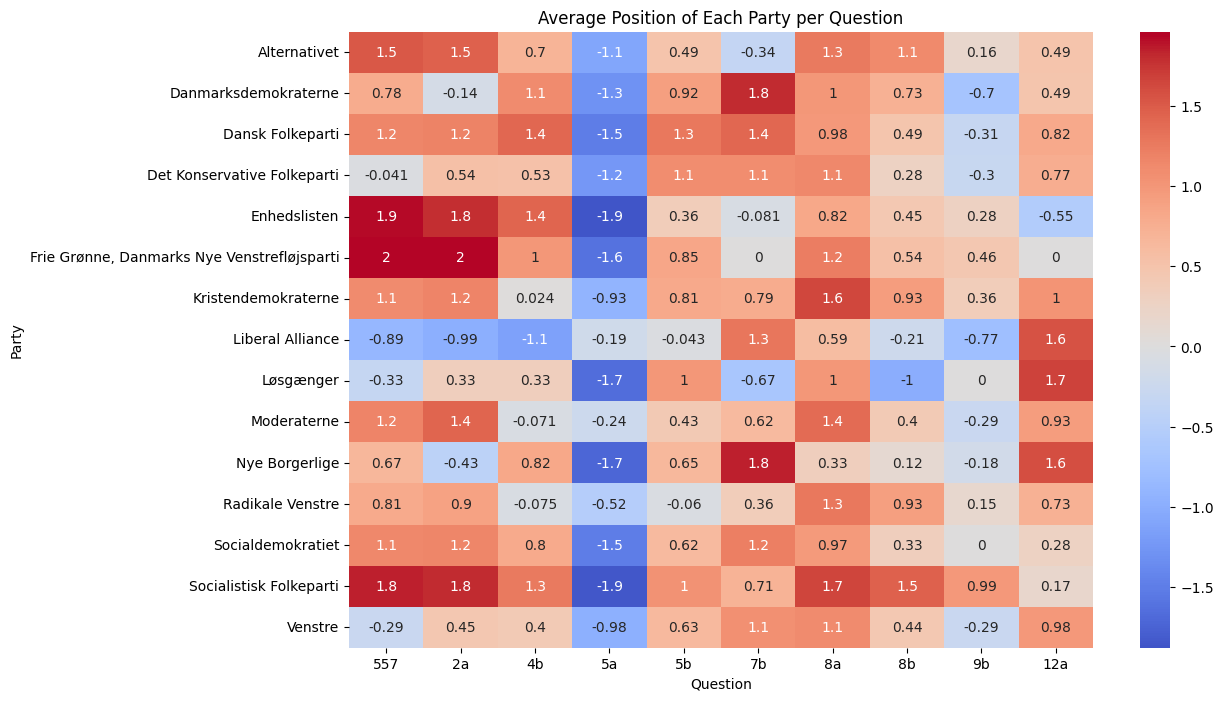

In [291]:
# Plot the data
# Heatmap to display average responses of each party for all questions
plt.figure(figsize=(12, 8))
sns.heatmap(party_averages, annot=True, cmap="coolwarm", center=0)
plt.title("Average Position of Each Party per Question")
plt.xlabel("Question")
plt.ylabel("Party")
plt.show()

### Encode Party Information

In [292]:
from sklearn.preprocessing import LabelEncoder

# Work with a copy of the alldata_cleaned DataFrame
party_answers = alldata_cleaned.copy()

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit and transform the 'parti' column
party_answers['parti_encoded'] = label_encoder.fit_transform(party_answers['parti'])

# Create a mapping from encoded labels to original party names
party_mapping = dict(zip(party_answers['parti_encoded'], party_answers['parti']))
print("Party encoding mapping:", party_mapping)

# Now, group by 'parti_encoded' if needed, but with the encoding applied beforehand
grouped_party_answers = party_answers.groupby('parti_encoded')[filtered_question_columns]



Party encoding mapping: {9: 'Moderaterne', 13: 'Socialistisk Folkeparti', 0: 'Alternativet', 8: 'Løsgænger', 4: 'Enhedslisten', 1: 'Danmarksdemokraterne', 14: 'Venstre', 5: 'Frie Grønne, Danmarks Nye Venstrefløjsparti', 2: 'Dansk Folkeparti', 6: 'Kristendemokraterne', 7: 'Liberal Alliance', 10: 'Nye Borgerlige', 3: 'Det Konservative Folkeparti', 11: 'Radikale Venstre', 12: 'Socialdemokratiet'}


### Cluster Analysis

##### K-means & PCA

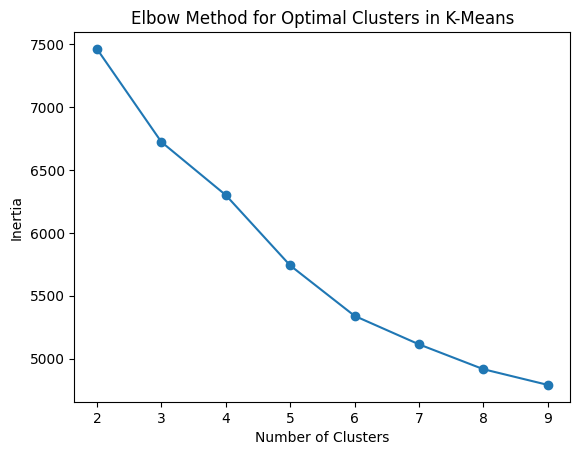

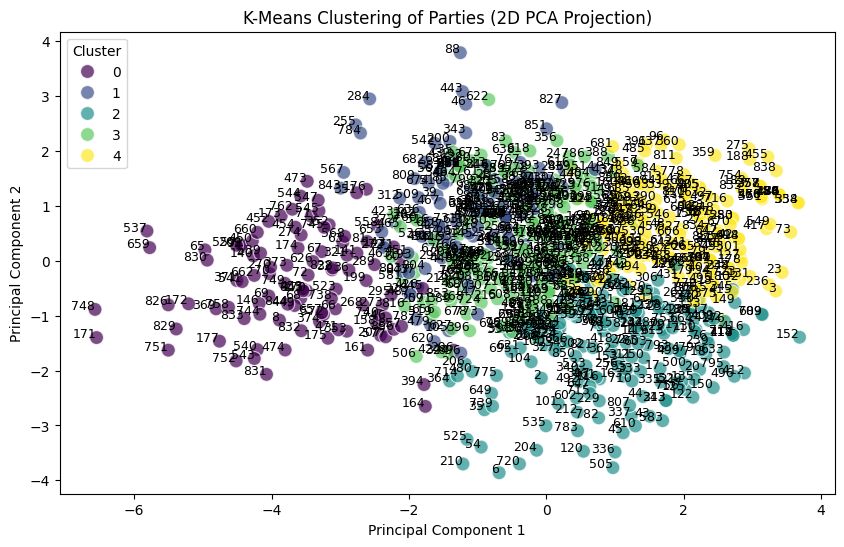

In [293]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Perform K-Means clustering (try a range of clusters to find optimal number)
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(party_answers[filtered_question_columns])
    inertia.append(kmeans.inertia_)

# Plot inertia to help identify the optimal number of clusters
plt.plot(range(2, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters in K-Means')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Reduce the dimensionality of the data to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(party_answers[filtered_question_columns])

# Perform K-Means clustering with optimal clusters
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(party_answers[filtered_question_columns])

# Plot the 2D projection with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=kmeans_labels, palette="viridis", s=100, alpha=0.7)
plt.title("K-Means Clustering of Parties (2D PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Annotate each point with the party name
for i, party in enumerate(party_answers.index):
    plt.text(reduced_data[i, 0], reduced_data[i, 1], party, fontsize=9, ha='right')
plt.legend(title="Cluster", loc='best')
plt.show()

##### Heiarchial Clustering

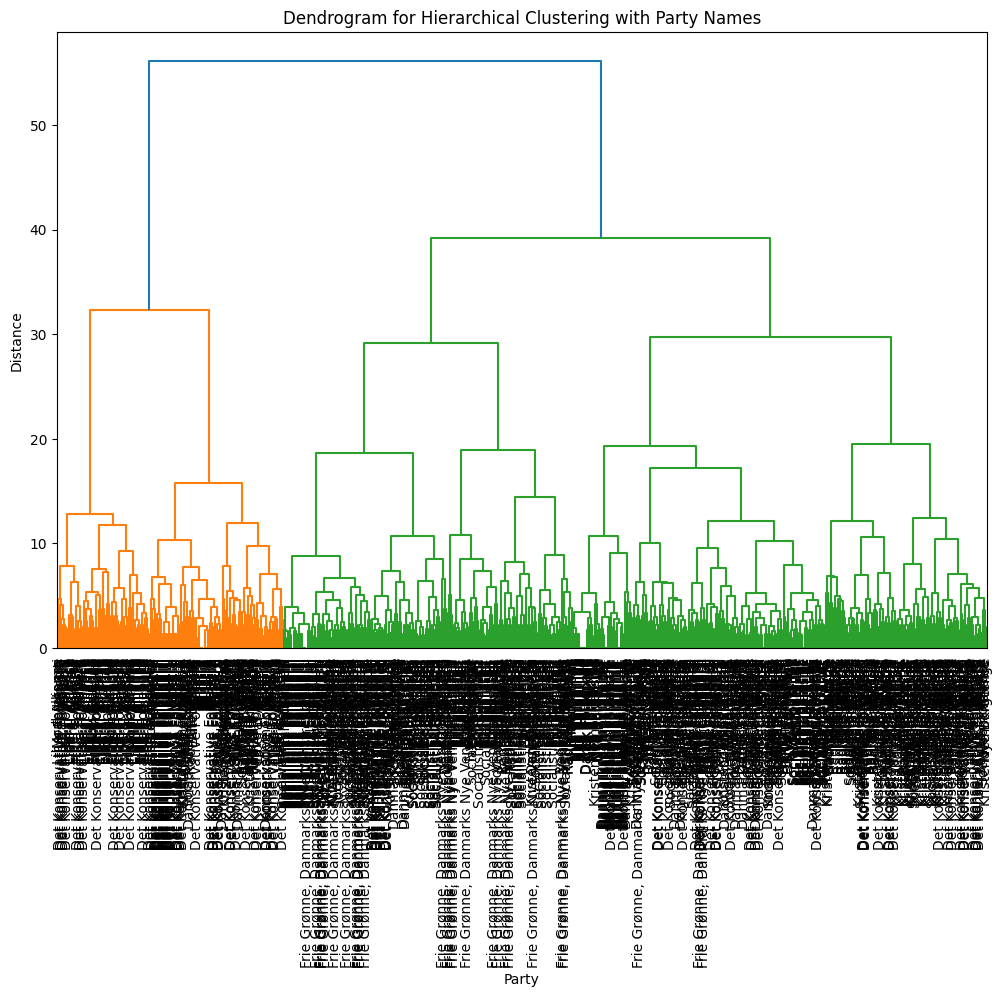

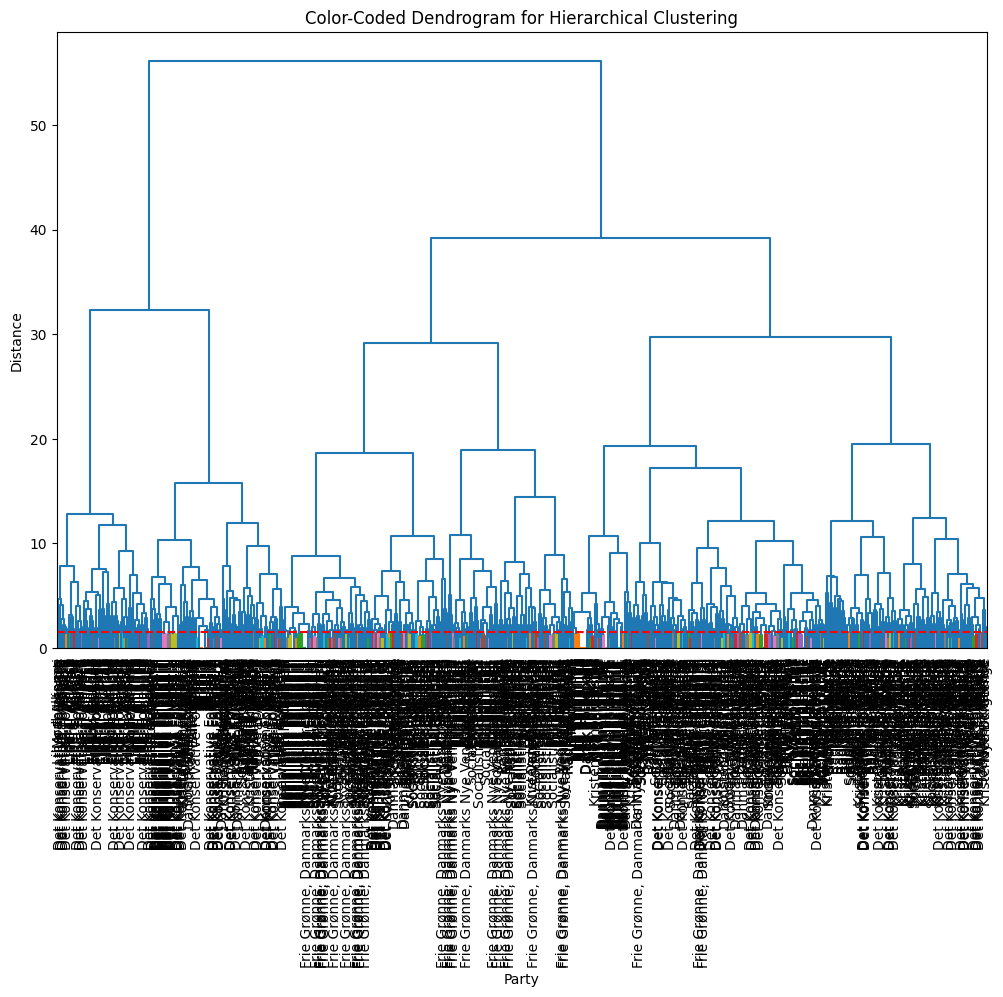

In [294]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt

# Ensure 'parti_encoded' is correctly aligned
labels_for_dendrogram = [party_mapping[label] for label in party_answers['parti_encoded']]

# Perform hierarchical clustering on the question columns directly
linkage_matrix = linkage(party_answers[filtered_question_columns], method='ward')

# Plot the dendrogram with mapped party labels
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=labels_for_dendrogram, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram for Hierarchical Clustering with Party Names")
plt.xlabel("Party")
plt.ylabel("Distance")
plt.show()

# Set threshold for defining clusters in dendrogram
threshold = 1.5  # Adjust based on dendrogram structure

# Assign clusters based on the threshold
hierarchical_clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')

# Plot a color-coded dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=labels_for_dendrogram, leaf_rotation=90, leaf_font_size=10, color_threshold=threshold)
plt.title("Color-Coded Dendrogram for Hierarchical Clustering")
plt.xlabel("Party")
plt.ylabel("Distance")
plt.axhline(y=threshold, color='r', linestyle='--')  # Visual threshold line
plt.show()


##### DBSCAN Clustering

     Party  Cluster
0        0       -1
1        1       -1
2        2       -1
3        3       -1
4        4       -1
..     ...      ...
862    862       -1
863    863       -1
864    864       -1
865    865       -1
866    866       -1

[867 rows x 2 columns]


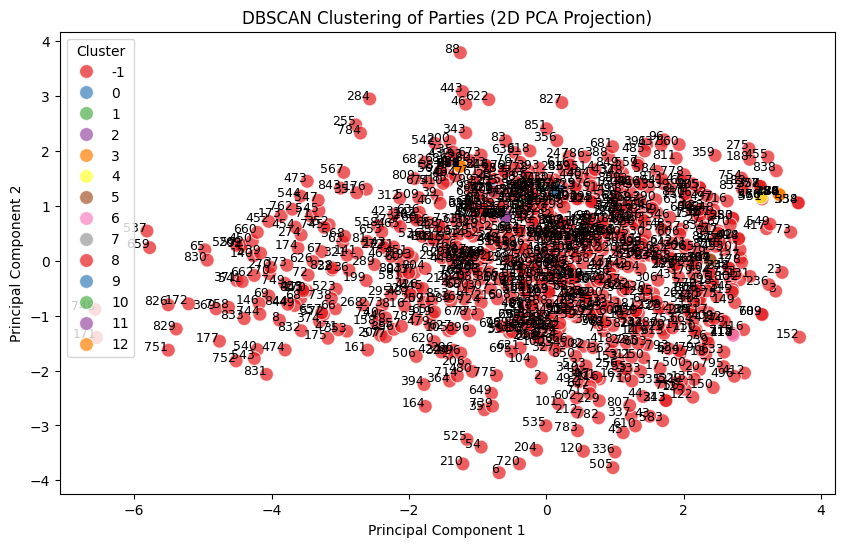

In [295]:
from sklearn.cluster import DBSCAN
import numpy as np

# Run DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=3)  # Tune eps and min_samples as needed
dbscan_labels = dbscan.fit_predict(party_answers[filtered_question_columns])

# Map cluster labels to party names for easier interpretation
clustered_parties = pd.DataFrame({'Party': party_answers.index, 'Cluster': dbscan_labels})
print(clustered_parties)

# Use PCA again for visualization
reduced_data_dbscan = pca.fit_transform(party_answers[filtered_question_columns])

# Plot DBSCAN clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data_dbscan[:, 0], y=reduced_data_dbscan[:, 1],
                hue=dbscan_labels, palette="Set1", s=100, alpha=0.7)
plt.title("DBSCAN Clustering of Parties (2D PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Annotate with party names for core samples
for i, party in enumerate(party_answers.index):
    plt.text(reduced_data_dbscan[i, 0], reduced_data_dbscan[i, 1], party, fontsize=9, ha='right')
plt.legend(title="Cluster", loc='best')
plt.show()